<a href="https://colab.research.google.com/github/dragoa/MachineLearning/blob/NLP/ML-NLP/C5_SequenceModels/00_Building_a_Recurrent_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building your Recurrent Neural Network - Step by Step

Welcome to Course 5's first assignment, where you'll be implementing key components of a Recurrent Neural Network, or RNN, in NumPy!

By the end of this assignment, you'll be able to:

* Define notation for building sequence models
* Describe the architecture of a basic RNN
* Identify the main components of an LSTM
* Implement backpropagation through time for a basic RNN and an LSTM
* Give examples of several types of RNN

**Recurrent Neural Networks (RNN) are very effective for Natural Language Processing and other sequence tasks because they have "memory."** They can read inputs $x^{\langle t \rangle}$ (such as words) one at a time, and remember some contextual information through the hidden layer activations that get passed from one time step to the next. This allows a unidirectional (one-way) RNN to take information from the past to process later inputs. A bidirectional (two-way) RNN can take context from both the past and the future, much like Marty McFly.

**Notation**:
- Superscript $[l]$ denotes an object associated with the $l^{th}$ layer.

- Superscript $(i)$ denotes an object associated with the $i^{th}$ example.

- Superscript $\langle t \rangle$ denotes an object at the $t^{th}$ time
step.
    
- Subscript $i$ denotes the $i^{th}$ entry of a vector.

**Example**:  
- $a^{(2)[3]<4>}_5$ denotes the activation of the 2nd training example (2), 3rd layer [3], 4th time step <4>, and 5th entry in the vector.

#### Pre-requisites
* You should already be familiar with `numpy`
* To refresh your knowledge of numpy, you can review course 1 of the specialization "Neural Networks and Deep Learning":
    * Specifically, review the week 2's practice assignment ["Python Basics with Numpy (optional assignment)"](https://www.coursera.org/learn/neural-networks-deep-learning/programming/isoAV/python-basics-with-numpy)
    
    
#### Be careful when modifying the starter code!
* When working on graded functions, please remember to only modify the code that is between:
```Python
#### START CODE HERE
```
and:
```Python
#### END CODE HERE
```
* In particular, avoid modifying the first line of graded routines. These start with:
```Python
# GRADED FUNCTION: routine_name
```
The automatic grader (autograder) needs these to locate the function - so even a change in spacing will cause issues with the autograder, returning 'failed' if any of these are modified or missing. Now, let's get started!

## Table of Content

- [Packages](#0)
- [1 - Forward Propagation for the Basic Recurrent Neural Network](#1)
    - [1.1 - RNN Cell](#1-1)
        - [Exercise 1 - rnn_cell_forward](#ex-1)
    - [1.2 - RNN Forward Pass](#1-2)
        - [Exercise 2 - rnn_forward](#ex-2)
- [2 - Long Short-Term Memory (LSTM) Network](#2)
    - [2.1 - LSTM Cell](#2-1)
        - [Exercise 3 - lstm_cell_forward](#ex-3)
    - [2.2 - Forward Pass for LSTM](#2-2)
        - [Exercise 4 - lstm_forward](#ex-4)
- [3 - Backpropagation in Recurrent Neural Networks (OPTIONAL / UNGRADED)](#3)
    - [3.1 - Basic RNN Backward Pass](#3-1)
        - [Exercise 5 - rnn_cell_backward](#ex-5)
        - [Exercise 6 - rnn_backward](#ex-6)
    - [3.2 - LSTM Backward Pass](#3-2)
        - [Exercise 7 - lstm_cell_backward](#ex-7)
    - [3.3 Backward Pass through the LSTM RNN](#3-3)
        - [Exercise 8 - lstm_backward](#ex-8)

<a name='0'></a>
## Packages

In [2]:
import numpy as np

from rnn_utils import *
from public_tests  import *

<a name='1'></a>
## 1 - Forward Propagation for the Basic Recurrent Neural Network

The basic RNN that you'll implement has the following structure:

In this example, $T_x = T_y$.

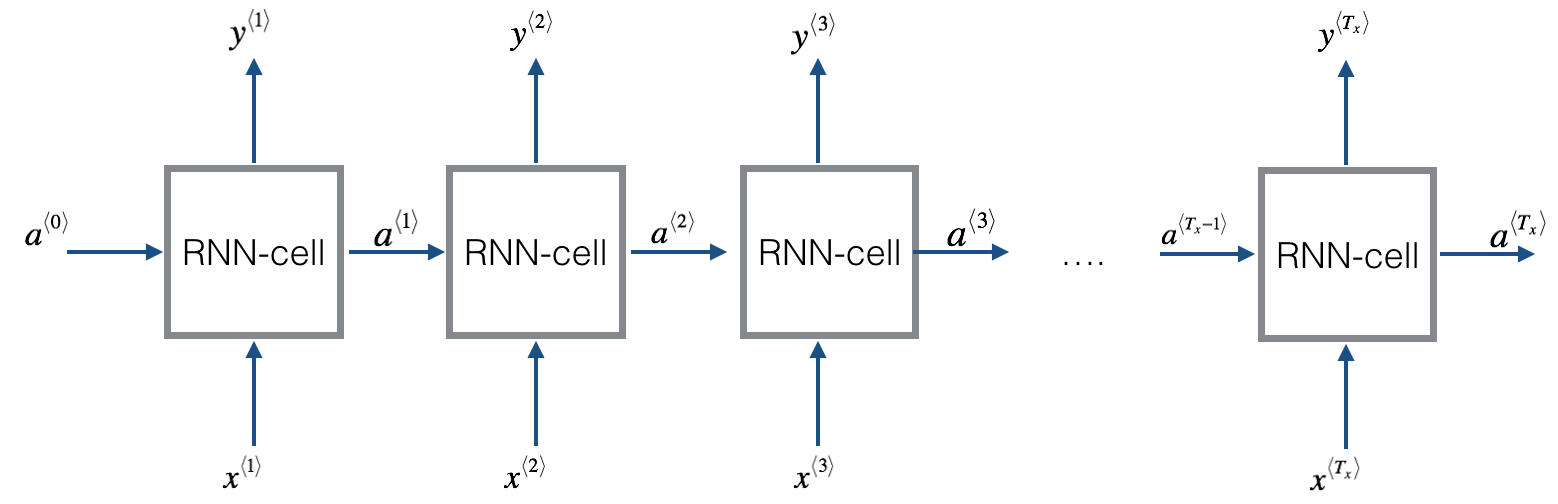

### Dimensions of input $x$

#### Input with $n_x$ number of units
* For a single time step of a single input example, $x^{(i) \langle t \rangle }$ is a one-dimensional input vector
* Using language as an example, a language with a 5000-word vocabulary could be one-hot encoded into a vector that has 5000 units.  So $x^{(i)\langle t \rangle}$ would have the shape (5000,)  
* The notation $n_x$ is used here to denote the number of units in a single time step of a single training example

#### Time steps of size $T_{x}$
* A recurrent neural network has multiple time steps, which you'll index with $t$.
* In the lessons, you saw a single training example $x^{(i)}$ consisting of multiple time steps $T_x$. In this notebook, $T_{x}$ will denote the number of timesteps in the longest sequence.

#### Batches of size $m$
* Let's say we have mini-batches, each with 20 training examples  
* To benefit from vectorization, you'll stack 20 columns of $x^{(i)}$ examples
* For example, this tensor has the shape (5000,20,10)
* You'll use $m$ to denote the number of training examples  
* So, the shape of a mini-batch is $(n_x,m,T_x)$

#### 3D Tensor of shape $(n_{x},m,T_{x})$
* The 3-dimensional tensor $x$ of shape $(n_x,m,T_x)$ represents the input $x$ that is fed into the RNN

#### Taking a 2D slice for each time step: $x^{\langle t \rangle}$
* At each time step, you'll use a mini-batch of training examples (not just a single example)
* So, for each time step $t$, you'll use a 2D slice of shape $(n_x,m)$
* This 2D slice is referred to as $x^{\langle t \rangle}$.  The variable name in the code is `xt`.

### Definition of hidden state $a$

* The activation $a^{\langle t \rangle}$ that is passed to the RNN from one time step to another is called a "hidden state."

### Dimensions of hidden state $a$

* Similar to the input tensor $x$, the hidden state for a single training example is a vector of length $n_{a}$
* If you include a mini-batch of $m$ training examples, the shape of a mini-batch is $(n_{a},m)$
* When you include the time step dimension, the shape of the hidden state is $(n_{a}, m, T_x)$
* You'll loop through the time steps with index $t$, and work with a 2D slice of the 3D tensor  
* This 2D slice is referred to as $a^{\langle t \rangle}$
* In the code, the variable names used are either `a_prev` or `a_next`, depending on the function being implemented
* The shape of this 2D slice is $(n_{a}, m)$

### Dimensions of prediction $\hat{y}$
* Similar to the inputs and hidden states, $\hat{y}$ is a 3D tensor of shape $(n_{y}, m, T_{y})$
    * $n_{y}$: number of units in the vector representing the prediction
    * $m$: number of examples in a mini-batch
    * $T_{y}$: number of time steps in the prediction
* For a single time step $t$, a 2D slice $\hat{y}^{\langle t \rangle}$ has shape $(n_{y}, m)$
* In the code, the variable names are:
    - `y_pred`: $\hat{y}$
    - `yt_pred`: $\hat{y}^{\langle t \rangle}$

Here's how you can implement an RNN:

### Steps:
1. Implement the calculations needed for one time step of the RNN.
2. Implement a loop over $T_x$ time steps in order to process all the inputs, one at a time.

<a name='1-1'></a>
### 1.1 - RNN Cell

You can think of the recurrent neural network as the repeated use of a single cell. First, you'll implement the computations for a single time step. The following figure describes the operations for a single time step of an RNN cell:



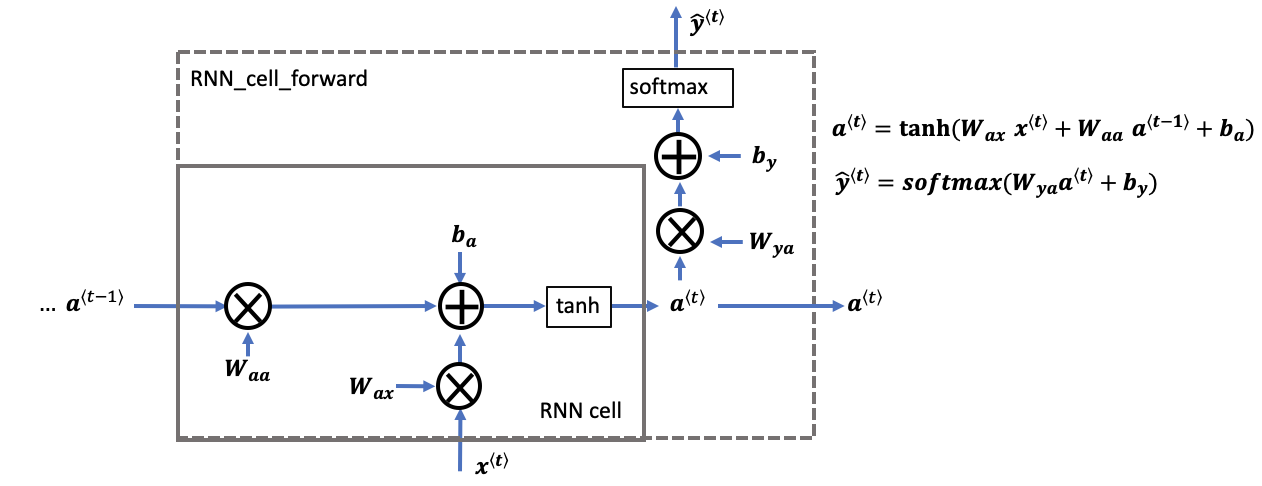<caption><center><font color='lightblue'><b>Figure 2</b>: Basic RNN cell. Takes as input $x^{\langle t \rangle}$ (current input) and $a^{\langle t - 1\rangle}$ (previous hidden state containing information from the past), and outputs $a^{\langle t \rangle}$ which is given to the next RNN cell and also used to predict $\hat{y}^{\langle t \rangle}$
</center></caption>

**`RNN cell` versus `RNN_cell_forward`**:
* Note that an RNN cell outputs the hidden state $a^{\langle t \rangle}$.  
    * `RNN cell` is shown in the figure as the inner box with solid lines  
* The function that you'll implement, `rnn_cell_forward`, also calculates the prediction $\hat{y}^{\langle t \rangle}$
    * `RNN_cell_forward` is shown in the figure as the outer box with dashed lines

<a name='ex-1'></a>
### Exercise 1 - rnn_cell_forward

Implement the RNN cell described in Figure 2.

**Instructions**:
1. Compute the hidden state with tanh activation: $a^{\langle t \rangle} = \tanh(W_{aa} a^{\langle t-1 \rangle} + W_{ax} x^{\langle t \rangle} + b_a)$
2. Using your new hidden state $a^{\langle t \rangle}$, compute the prediction $\hat{y}^{\langle t \rangle} = softmax(W_{ya} a^{\langle t \rangle} + b_y)$. (The function `softmax` is provided)
3. Store $(a^{\langle t \rangle}, a^{\langle t-1 \rangle}, x^{\langle t \rangle}, parameters)$ in a `cache`
4. Return $a^{\langle t \rangle}$ , $\hat{y}^{\langle t \rangle}$ and `cache`

#### Additional Hints
* A little more information on [numpy.tanh](https://numpy.org/devdocs/reference/generated/numpy.tanh.html)
* In this assignment, there's an existing `softmax` function for you to use.  It's located in the file 'rnn_utils.py' and has already been imported.
* For matrix multiplication, use [numpy.dot](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html)


In [3]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: rnn_cell_forward

def rnn_cell_forward(xt, a_prev, parameters):
    """
    Implements a single forward step of the RNN-cell as described in Figure (2)

    Arguments:
    xt -- your input data at timestep "t", numpy array of shape (n_x, m).
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        ba --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    Returns:
    a_next -- next hidden state, of shape (n_a, m)
    yt_pred -- prediction at timestep "t", numpy array of shape (n_y, m)
    cache -- tuple of values needed for the backward pass, contains (a_next, a_prev, xt, parameters)
    """

    # Retrieve parameters from "parameters"
    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]

    ### START CODE HERE ### (≈2 lines)
    a_next = np.tanh(np.dot(Wax,xt)+np.dot(Waa,a_prev)+ba)
    yt_pred = softmax(np.dot(Wya,a_next)+by)
    ### END CODE HERE ###

    # store values you need for backward propagation in cache
    cache = (a_next, a_prev, xt, parameters)

    return a_next, yt_pred, cache

In [4]:
np.random.seed(1)
xt_tmp = np.random.randn(3, 10)
a_prev_tmp = np.random.randn(5, 10)
parameters_tmp = {}
parameters_tmp['Waa'] = np.random.randn(5, 5)
parameters_tmp['Wax'] = np.random.randn(5, 3)
parameters_tmp['Wya'] = np.random.randn(2, 5)
parameters_tmp['ba'] = np.random.randn(5, 1)
parameters_tmp['by'] = np.random.randn(2, 1)

a_next_tmp, yt_pred_tmp, cache_tmp = rnn_cell_forward(xt_tmp, a_prev_tmp, parameters_tmp)
print("a_next[4] = \n", a_next_tmp[4])
print("a_next.shape = \n", a_next_tmp.shape)
print("yt_pred[1] =\n", yt_pred_tmp[1])
print("yt_pred.shape = \n", yt_pred_tmp.shape)

# UNIT TESTS
rnn_cell_forward_tests(rnn_cell_forward)

a_next[4] = 
 [ 0.59584544  0.18141802  0.61311866  0.99808218  0.85016201  0.99980978
 -0.18887155  0.99815551  0.6531151   0.82872037]
a_next.shape = 
 (5, 10)
yt_pred[1] =
 [0.9888161  0.01682021 0.21140899 0.36817467 0.98988387 0.88945212
 0.36920224 0.9966312  0.9982559  0.17746526]
yt_pred.shape = 
 (2, 10)
All tests passed


**Expected Output**:
```Python
a_next[4] =
 [ 0.59584544  0.18141802  0.61311866  0.99808218  0.85016201  0.99980978
 -0.18887155  0.99815551  0.6531151   0.82872037]
a_next.shape =
 (5, 10)
yt_pred[1] =
 [ 0.9888161   0.01682021  0.21140899  0.36817467  0.98988387  0.88945212
  0.36920224  0.9966312   0.9982559   0.17746526]
yt_pred.shape =
 (2, 10)

```

<a name='1-2'></a>
### 1.2 - RNN Forward Pass

- A recurrent neural network (RNN) is a repetition of the RNN cell that you've just built.
    - If your input sequence of data is 10 time steps long, then you will re-use the RNN cell 10 times
- Each cell takes two inputs at each time step:
    - $a^{\langle t-1 \rangle}$: The hidden state from the previous cell
    - $x^{\langle t \rangle}$: The current time step's input data
- It has two outputs at each time step:
    - A hidden state ($a^{\langle t \rangle}$)
    - A prediction ($y^{\langle t \rangle}$)
- The weights and biases $(W_{aa}, b_{a}, W_{ax}, b_{x})$ are re-used each time step
    - They are maintained between calls to `rnn_cell_forward` in the 'parameters' dictionary


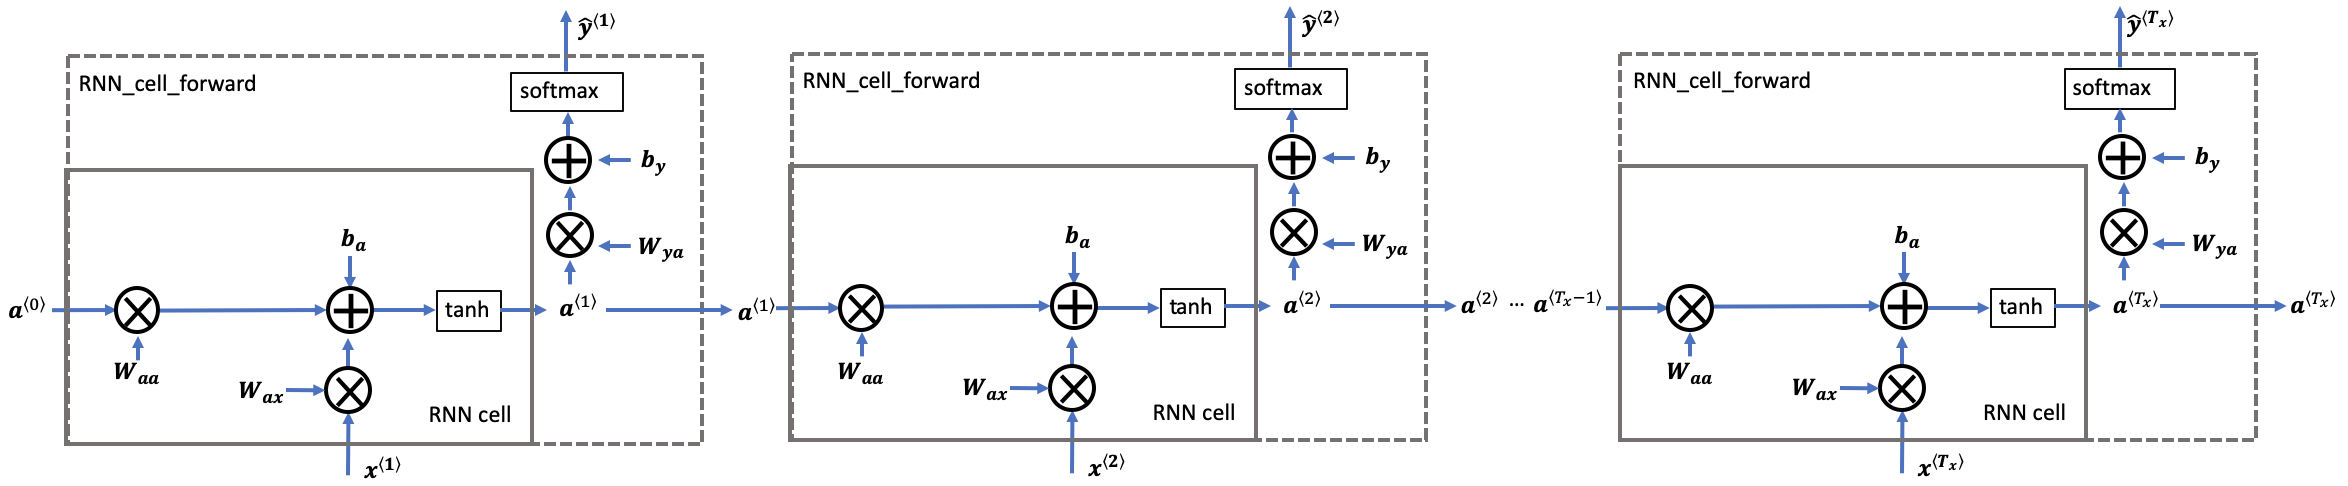<caption><center><font color='lightblue'><b>Figure 3</b>: Basic RNN. The input sequence $x = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, ..., x^{\langle T_x \rangle})$  is carried over $T_x$ time steps. The network outputs $y = (y^{\langle 1 \rangle}, y^{\langle 2 \rangle}, ..., y^{\langle T_x \rangle})$. </center></caption>

<a name='ex-2'></a>
### Exercise 2 - rnn_forward

Implement the forward propagation of the RNN described in Figure 3.

**Instructions**:
* Create a 3D array of zeros, $a$ of shape $(n_{a}, m, T_{x})$ that will store all the hidden states computed by the RNN
* Create a 3D array of zeros, $\hat{y}$, of shape $(n_{y}, m, T_{x})$ that will store the predictions  
    - Note that in this case, $T_{y} = T_{x}$ (the prediction and input have the same number of time steps)
* Initialize the 2D hidden state `a_next` by setting it equal to the initial hidden state, $a_{0}$
* At each time step $t$:
    - Get $x^{\langle t \rangle}$, which is a 2D slice of $x$ for a single time step $t$
        - $x^{\langle t \rangle}$ has shape $(n_{x}, m)$
        - $x$ has shape $(n_{x}, m, T_{x})$
    - Update the 2D hidden state $a^{\langle t \rangle}$ (variable name `a_next`), the prediction $\hat{y}^{\langle t \rangle}$ and the cache by running `rnn_cell_forward`
        - $a^{\langle t \rangle}$ has shape $(n_{a}, m)$
    - Store the 2D hidden state in the 3D tensor $a$, at the $t^{th}$ position
        - $a$ has shape $(n_{a}, m, T_{x})$
    - Store the 2D $\hat{y}^{\langle t \rangle}$ prediction (variable name `yt_pred`) in the 3D tensor $\hat{y}_{pred}$ at the $t^{th}$ position
        - $\hat{y}^{\langle t \rangle}$ has shape $(n_{y}, m)$
        - $\hat{y}$ has shape $(n_{y}, m, T_x)$
    - Append the cache to the list of caches
* Return the 3D tensor $a$ and $\hat{y}$, as well as the list of caches

#### Additional Hints
- Some helpful documentation on [np.zeros](https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros.html)
- If you have a 3 dimensional numpy array and are indexing by its third dimension, you can use array slicing like this: `var_name[:,:,i]`

In [5]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: rnn_forward

def rnn_forward(x, a0, parameters):
    """
    Implement the forward propagation of the recurrent neural network described in Figure (3).

    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        ba --  Bias numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)

    Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    yt_pred -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of caches, x)
    """

    # Initialize "caches" which will contain the list of all caches
    caches = []

    # Retrieve dimensions from shapes of x and parameters["Wya"]
    n_x, m, T_x = x.shape
    n_y, n_a = parameters["Wya"].shape

    ### START CODE HERE ###
    # Hidden states for every time-step
    a = np.zeros((n_a, m, T_x))
    y_pred = np.zeros((n_y, m, T_x))

    a_next = a0

    for t in range(T_x):
      x_t = x[:,:,t]
      a_next, yt_pred, cache = rnn_cell_forward(x_t, a_next, parameters)

      a[:,:,t] = a_next
      y_pred[:,:,t] = yt_pred
      caches.append(cache)
    ### END CODE HERE ###

    # store values needed for backward propagation in cache
    caches = (caches, x)

    return a, y_pred, caches

In [6]:
np.random.seed(1)
x_tmp = np.random.randn(3, 10, 4)
a0_tmp = np.random.randn(5, 10)
parameters_tmp = {}
parameters_tmp['Waa'] = np.random.randn(5, 5)
parameters_tmp['Wax'] = np.random.randn(5, 3)
parameters_tmp['Wya'] = np.random.randn(2, 5)
parameters_tmp['ba'] = np.random.randn(5, 1)
parameters_tmp['by'] = np.random.randn(2, 1)

a_tmp, y_pred_tmp, caches_tmp = rnn_forward(x_tmp, a0_tmp, parameters_tmp)
print("a[4][1] = \n", a_tmp[4][1])
print("a.shape = \n", a_tmp.shape)
print("y_pred[1][3] =\n", y_pred_tmp[1][3])
print("y_pred.shape = \n", y_pred_tmp.shape)
print("caches[1][1][3] =\n", caches_tmp[1][1][3])
print("len(caches) = \n", len(caches_tmp))

#UNIT TEST
rnn_forward_test(rnn_forward)

a[4][1] = 
 [-0.99999375  0.77911235 -0.99861469 -0.99833267]
a.shape = 
 (5, 10, 4)
y_pred[1][3] =
 [0.79560373 0.86224861 0.11118257 0.81515947]
y_pred.shape = 
 (2, 10, 4)
caches[1][1][3] =
 [-1.1425182  -0.34934272 -0.20889423  0.58662319]
len(caches) = 
 2
All tests passed


**Expected Output**:

```Python
a[4][1] =
 [-0.99999375  0.77911235 -0.99861469 -0.99833267]
a.shape =
 (5, 10, 4)
y_pred[1][3] =
 [ 0.79560373  0.86224861  0.11118257  0.81515947]
y_pred.shape =
 (2, 10, 4)
caches[1][1][3] =
 [-1.1425182  -0.34934272 -0.20889423  0.58662319]
len(caches) =
 2
```

### Congratulations!

You've successfully built the forward propagation of a recurrent neural network from scratch. Nice work!

#### Situations when this RNN will perform better:
- This will work well enough for some applications, but it suffers from **vanishing gradients**.
- The RNN works best when each output $\hat{y}^{\langle t \rangle}$ can be estimated using "local" context.  
- "Local" context refers to information that is close to the prediction's time step $t$.
- More formally, local context refers to inputs $x^{\langle t' \rangle}$ and predictions $\hat{y}^{\langle t \rangle}$ where $t'$ is close to $t$.

<font color='orange'><b>What you should remember:</b>
* The recurrent neural network, or RNN, is essentially the repeated use of a single cell.
* A basic RNN reads inputs one at a time, and remembers information through the hidden layer activations (hidden states) that are passed from one time step to the next.
    * The time step dimension determines how many times to re-use the RNN cell
* Each cell takes two inputs at each time step:
    * The hidden state from the previous cell
    * The current time step's input data
* Each cell has two outputs at each time step:
    * A hidden state
    * A prediction
</font>

In the next section, you'll build a more complex model, the LSTM, which is better at addressing vanishing gradients. The LSTM is better able to remember a piece of information and save it for many time steps.  

<a name='2'></a>
## 2 - Long Short-Term Memory (LSTM) Network

The following figure shows the operations of an LSTM cell:

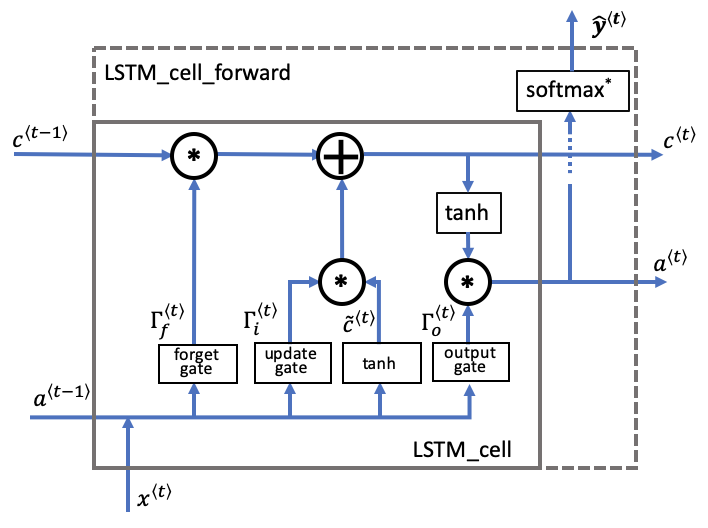<caption><center><font color='lightblue'><b>Figure 4</b>: LSTM cell. This tracks and updates a "cell state," or memory variable $c^{\langle t \rangle}$ at every time step, which can be different from $a^{\langle t \rangle}$.  
Note, the $softmax^{}$ includes a dense layer and softmax.</center></caption>

Similar to the RNN example above, you'll begin by implementing the LSTM cell for a single time step. Then, you'll iteratively call it from inside a "for loop" to have it process an input with $T_x$ time steps.

### Overview of gates and states

#### Forget gate $\mathbf{\Gamma}_{f}$

* Let's assume you are reading words in a piece of text, and plan to use an LSTM to keep track of grammatical structures, such as whether the subject is singular ("puppy") or plural ("puppies").
* If the subject changes its state (from a singular word to a plural word), the memory of the previous state becomes outdated, so you'll "forget" that outdated state.
* The "forget gate" is a tensor containing values between 0 and 1.
    * If a unit in the forget gate has a value close to 0, the LSTM will "forget" the stored state in the corresponding unit of the previous cell state.
    * If a unit in the forget gate has a value close to 1, the LSTM will mostly remember the corresponding value in the stored state.

##### Equation

$$\mathbf{\Gamma}_f^{\langle t \rangle} = \sigma(\mathbf{W}_f[\mathbf{a}^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_f)\tag{1} $$

##### Explanation of the equation:

* $\mathbf{W_{f}}$ contains weights that govern the forget gate's behavior.
* The previous time step's hidden state $[a^{\langle t-1 \rangle}$ and current time step's input $x^{\langle t \rangle}]$ are concatenated together and multiplied by $\mathbf{W_{f}}$.
* A sigmoid function is used to make each of the gate tensor's values $\mathbf{\Gamma}_f^{\langle t \rangle}$ range from 0 to 1.
* The forget gate  $\mathbf{\Gamma}_f^{\langle t \rangle}$ has the same dimensions as the previous cell state $c^{\langle t-1 \rangle}$.
* This means that the two can be multiplied together, element-wise.
* Multiplying the tensors $\mathbf{\Gamma}_f^{\langle t \rangle} * \mathbf{c}^{\langle t-1 \rangle}$ is like applying a mask over the previous cell state.
* If a single value in $\mathbf{\Gamma}_f^{\langle t \rangle}$ is 0 or close to 0, then the product is close to 0.
    * This keeps the information stored in the corresponding unit in $\mathbf{c}^{\langle t-1 \rangle}$ from being remembered for the next time step.
* Similarly, if one value is close to 1, the product is close to the original value in the previous cell state.
    * The LSTM will keep the information from the corresponding unit of $\mathbf{c}^{\langle t-1 \rangle}$, to be used in the next time step.
    
##### Variable names in the code
The variable names in the code are similar to the equations, with slight differences.  
* `Wf`: forget gate weight $\mathbf{W}_{f}$
* `bf`: forget gate bias $\mathbf{b}_{f}$
* `ft`: forget gate $\Gamma_f^{\langle t \rangle}$

#### Candidate value $\tilde{\mathbf{c}}^{\langle t \rangle}$
* The candidate value is a tensor containing information from the current time step that **may** be stored in the current cell state $\mathbf{c}^{\langle t \rangle}$.
* The parts of the candidate value that get passed on depend on the update gate.
* The candidate value is a tensor containing values that range from -1 to 1.
* The tilde "~" is used to differentiate the candidate $\tilde{\mathbf{c}}^{\langle t \rangle}$ from the cell state $\mathbf{c}^{\langle t \rangle}$.

##### Equation
$$\mathbf{\tilde{c}}^{\langle t \rangle} = \tanh\left( \mathbf{W}_{c} [\mathbf{a}^{\langle t - 1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_{c} \right) \tag{3}$$

##### Explanation of the equation
* The *tanh* function produces values between -1 and 1.


##### Variable names in the code
* `cct`: candidate value $\mathbf{\tilde{c}}^{\langle t \rangle}$

#### Update gate $\mathbf{\Gamma}_{i}$

* You use the update gate to decide what aspects of the candidate $\tilde{\mathbf{c}}^{\langle t \rangle}$ to add to the cell state $c^{\langle t \rangle}$.
* The update gate decides what parts of a "candidate" tensor $\tilde{\mathbf{c}}^{\langle t \rangle}$ are passed onto the cell state $\mathbf{c}^{\langle t \rangle}$.
* The update gate is a tensor containing values between 0 and 1.
    * When a unit in the update gate is close to 1, it allows the value of the candidate $\tilde{\mathbf{c}}^{\langle t \rangle}$ to be passed onto the hidden state $\mathbf{c}^{\langle t \rangle}$
    * When a unit in the update gate is close to 0, it prevents the corresponding value in the candidate from being passed onto the hidden state.
* Notice that the subscript "i" is used and not "u", to follow the convention used in the literature.

##### Equation

$$\mathbf{\Gamma}_i^{\langle t \rangle} = \sigma(\mathbf{W}_i[a^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_i)\tag{2} $$

##### Explanation of the equation

* Similar to the forget gate, here $\mathbf{\Gamma}_i^{\langle t \rangle}$, the sigmoid produces values between 0 and 1.
* The update gate is multiplied element-wise with the candidate, and this product ($\mathbf{\Gamma}_{i}^{\langle t \rangle} * \tilde{c}^{\langle t \rangle}$) is used in determining the cell state $\mathbf{c}^{\langle t \rangle}$.

##### Variable names in code (Please note that they're different than the equations)
In the code, you'll use the variable names found in the academic literature.  These variables don't use "u" to denote "update".
* `Wi` is the update gate weight $\mathbf{W}_i$ (not "Wu")
* `bi` is the update gate bias $\mathbf{b}_i$ (not "bu")
* `it` is the update gate $\mathbf{\Gamma}_i^{\langle t \rangle}$ (not "ut")

#### Cell state $\mathbf{c}^{\langle t \rangle}$

* The cell state is the "memory" that gets passed onto future time steps.
* The new cell state $\mathbf{c}^{\langle t \rangle}$ is a combination of the previous cell state and the candidate value.

##### Equation

$$ \mathbf{c}^{\langle t \rangle} = \mathbf{\Gamma}_f^{\langle t \rangle}* \mathbf{c}^{\langle t-1 \rangle} + \mathbf{\Gamma}_{i}^{\langle t \rangle} *\mathbf{\tilde{c}}^{\langle t \rangle} \tag{4} $$

##### Explanation of equation
* The previous cell state $\mathbf{c}^{\langle t-1 \rangle}$ is adjusted (weighted) by the forget gate $\mathbf{\Gamma}_{f}^{\langle t \rangle}$
* and the candidate value $\tilde{\mathbf{c}}^{\langle t \rangle}$, adjusted (weighted) by the update gate $\mathbf{\Gamma}_{i}^{\langle t \rangle}$

##### Variable names and shapes in the code
* `c`: cell state, including all time steps, $\mathbf{c}$ shape $(n_{a}, m, T_x)$
* `c_next`: new (next) cell state, $\mathbf{c}^{\langle t \rangle}$ shape $(n_{a}, m)$
* `c_prev`: previous cell state, $\mathbf{c}^{\langle t-1 \rangle}$, shape $(n_{a}, m)$

#### Output gate $\mathbf{\Gamma}_{o}$

* The output gate decides what gets sent as the prediction (output) of the time step.
* The output gate is like the other gates, in that it contains values that range from 0 to 1.

##### Equation

$$ \mathbf{\Gamma}_o^{\langle t \rangle}=  \sigma(\mathbf{W}_o[\mathbf{a}^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_{o})\tag{5}$$

##### Explanation of the equation
* The output gate is determined by the previous hidden state $\mathbf{a}^{\langle t-1 \rangle}$ and the current input $\mathbf{x}^{\langle t \rangle}$
* The sigmoid makes the gate range from 0 to 1.


##### Variable names in the code
* `Wo`: output gate weight, $\mathbf{W_o}$
* `bo`: output gate bias, $\mathbf{b_o}$
* `ot`: output gate, $\mathbf{\Gamma}_{o}^{\langle t \rangle}$

#### Hidden state $\mathbf{a}^{\langle t \rangle}$

* The hidden state gets passed to the LSTM cell's next time step.
* It is used to determine the three gates ($\mathbf{\Gamma}_{f}, \mathbf{\Gamma}_{u}, \mathbf{\Gamma}_{o}$) of the next time step.
* The hidden state is also used for the prediction $y^{\langle t \rangle}$.

##### Equation

$$ \mathbf{a}^{\langle t \rangle} = \mathbf{\Gamma}_o^{\langle t \rangle} * \tanh(\mathbf{c}^{\langle t \rangle})\tag{6} $$

##### Explanation of equation
* The hidden state $\mathbf{a}^{\langle t \rangle}$ is determined by the cell state $\mathbf{c}^{\langle t \rangle}$ in combination with the output gate $\mathbf{\Gamma}_{o}$.
* The cell state state is passed through the `tanh` function to rescale values between -1 and 1.
* The output gate acts like a "mask" that either preserves the values of $\tanh(\mathbf{c}^{\langle t \rangle})$ or keeps those values from being included in the hidden state $\mathbf{a}^{\langle t \rangle}$

##### Variable names  and shapes in the code
* `a`: hidden state, including time steps.  $\mathbf{a}$ has shape $(n_{a}, m, T_{x})$
* `a_prev`: hidden state from previous time step. $\mathbf{a}^{\langle t-1 \rangle}$ has shape $(n_{a}, m)$
* `a_next`: hidden state for next time step.  $\mathbf{a}^{\langle t \rangle}$ has shape $(n_{a}, m)$

#### Prediction $\mathbf{y}^{\langle t \rangle}_{pred}$
* The prediction in this use case is a classification, so you'll use a softmax.

The equation is:
$$\mathbf{y}^{\langle t \rangle}_{pred} = \textrm{softmax}(\mathbf{W}_{y} \mathbf{a}^{\langle t \rangle} + \mathbf{b}_{y})$$

##### Variable names and shapes in the code
* `y_pred`: prediction, including all time steps. $\mathbf{y}_{pred}$ has shape $(n_{y}, m, T_{x})$.  Note that $(T_{y} = T_{x})$ for this example.
* `yt_pred`: prediction for the current time step $t$. $\mathbf{y}^{\langle t \rangle}_{pred}$ has shape $(n_{y}, m)$

<a name='2-1'></a>
### 2.1 - LSTM Cell

<a name='ex-3'></a>
### Exercise 3 - lstm_cell_forward

Implement the LSTM cell described in Figure 4.

**Instructions**:
1. Concatenate the hidden state $a^{\langle t-1 \rangle}$ and input $x^{\langle t \rangle}$ into a single matrix:  

$$concat = \begin{bmatrix} a^{\langle t-1 \rangle} \\ x^{\langle t \rangle} \end{bmatrix}$$  

2. Compute all formulas (1 through 6) for the gates, hidden state, and cell state.
3. Compute the prediction $y^{\langle t \rangle}$.


#### Additional Hints
* You can use [numpy.concatenate](https://docs.scipy.org/doc/numpy/reference/generated/numpy.concatenate.html).  Check which value to use for the `axis` parameter.
* The functions `sigmoid()` and `softmax` are imported from `rnn_utils.py`.
* Some docs for [numpy.tanh](https://docs.scipy.org/doc/numpy/reference/generated/numpy.tanh.html)
* Use [numpy.dot](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) for matrix multiplication.
* Notice that the variable names `Wi`, `bi` refer to the weights and biases of the **update** gate.  There are no variables named "Wu" or "bu" in this function.

In [40]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: lstm_cell_forward

def lstm_cell_forward(xt, a_prev, c_prev, parameters):
    """
    Implement a single forward step of the LSTM-cell as described in Figure (4)

    Arguments:
    xt -- your input data at timestep "t", numpy array of shape (n_x, m).
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    c_prev -- Memory state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        bi -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc --  Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        bo --  Bias of the output gate, numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)

    Returns:
    a_next -- next hidden state, of shape (n_a, m)
    c_next -- next memory state, of shape (n_a, m)
    yt_pred -- prediction at timestep "t", numpy array of shape (n_y, m)
    cache -- tuple of values needed for the backward pass, contains (a_next, c_next, a_prev, c_prev, xt, parameters)

    Note: ft/it/ot stand for the forget/update/output gates, cct stands for the candidate value (c tilde),
          c stands for the cell state (memory)
    """

    # Retrieve parameters from "parameters"
    Wf = parameters["Wf"] # forget gate weight
    bf = parameters["bf"]
    Wi = parameters["Wi"] # update gate weight (notice the variable name)
    bi = parameters["bi"] # (notice the variable name)
    Wc = parameters["Wc"] # candidate value weight
    bc = parameters["bc"]
    Wo = parameters["Wo"] # output gate weight
    bo = parameters["bo"]
    Wy = parameters["Wy"] # prediction weight
    by = parameters["by"]

    # Retrieve dimensions from shapes of xt and Wy
    n_x, m = xt.shape
    n_y, n_a = Wy.shape

    ### START CODE HERE ###
    # concatenation matrix of shape (n_a + n_x, n_a)
    concat = np.concatenate((a_prev, xt), axis=0)

    # forget gate
    ft = sigmoid(np.dot(Wf, concat) + bf)

    # update gate
    it = sigmoid(np.dot(Wi, concat) + bi)

    # output gate
    ot = sigmoid(np.dot(Wo, concat) + bo)

    # candidate cell
    cct = np.tanh(np.dot(Wc, concat) + bc)

    # cell state c_next
    c_next = c_prev*ft + cct*it

    # activation (hidden state)
    a_next = ot*(np.tanh(c_next))

    # prediction y
    yt_pred = softmax(Wy.dot(a_next) + by)
    ### END CODE HERE ###

    # store values needed for backward propagation in cache
    cache = (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters)

    return a_next, c_next, yt_pred, cache

In [41]:
np.random.seed(1)
xt_tmp = np.random.randn(3, 10)
a_prev_tmp = np.random.randn(5, 10)
c_prev_tmp = np.random.randn(5, 10)
parameters_tmp = {}
parameters_tmp['Wf'] = np.random.randn(5, 5 + 3)
parameters_tmp['bf'] = np.random.randn(5, 1)
parameters_tmp['Wi'] = np.random.randn(5, 5 + 3)
parameters_tmp['bi'] = np.random.randn(5, 1)
parameters_tmp['Wo'] = np.random.randn(5, 5 + 3)
parameters_tmp['bo'] = np.random.randn(5, 1)
parameters_tmp['Wc'] = np.random.randn(5, 5 + 3)
parameters_tmp['bc'] = np.random.randn(5, 1)
parameters_tmp['Wy'] = np.random.randn(2, 5)
parameters_tmp['by'] = np.random.randn(2, 1)

a_next_tmp, c_next_tmp, yt_tmp, cache_tmp = lstm_cell_forward(xt_tmp, a_prev_tmp, c_prev_tmp, parameters_tmp)

print("a_next[4] = \n", a_next_tmp[4])
print("a_next.shape = ", a_next_tmp.shape)
print("c_next[2] = \n", c_next_tmp[2])
print("c_next.shape = ", c_next_tmp.shape)
print("yt[1] =", yt_tmp[1])
print("yt.shape = ", yt_tmp.shape)
print("cache[1][3] =\n", cache_tmp[1][3])
print("len(cache) = ", len(cache_tmp))

# UNIT TEST
lstm_cell_forward_test(lstm_cell_forward)

a_next[4] = 
 [-0.66408471  0.0036921   0.02088357  0.22834167 -0.85575339  0.00138482
  0.76566531  0.34631421 -0.00215674  0.43827275]
a_next.shape =  (5, 10)
c_next[2] = 
 [ 0.63267805  1.00570849  0.35504474  0.20690913 -1.64566718  0.11832942
  0.76449811 -0.0981561  -0.74348425 -0.26810932]
c_next.shape =  (5, 10)
yt[1] = [0.79913913 0.15986619 0.22412122 0.15606108 0.97057211 0.31146381
 0.00943007 0.12666353 0.39380172 0.07828381]
yt.shape =  (2, 10)
cache[1][3] =
 [-0.16263996  1.03729328  0.72938082 -0.54101719  0.02752074 -0.30821874
  0.07651101 -1.03752894  1.41219977 -0.37647422]
len(cache) =  10
All tests passed


**Expected Output**:

```Python
a_next[4] =
 [-0.66408471  0.0036921   0.02088357  0.22834167 -0.85575339  0.00138482
  0.76566531  0.34631421 -0.00215674  0.43827275]
a_next.shape =  (5, 10)
c_next[2] =
 [ 0.63267805  1.00570849  0.35504474  0.20690913 -1.64566718  0.11832942
  0.76449811 -0.0981561  -0.74348425 -0.26810932]
c_next.shape =  (5, 10)
yt[1] = [ 0.79913913  0.15986619  0.22412122  0.15606108  0.97057211  0.31146381
  0.00943007  0.12666353  0.39380172  0.07828381]
yt.shape =  (2, 10)
cache[1][3] =
 [-0.16263996  1.03729328  0.72938082 -0.54101719  0.02752074 -0.30821874
  0.07651101 -1.03752894  1.41219977 -0.37647422]
len(cache) =  10
```

<a name='2-2'></a>
### 2.2 - Forward Pass for LSTM

Now that you have implemented one step of an LSTM, you can iterate this over it using a for loop to process a sequence of $T_x$ inputs.

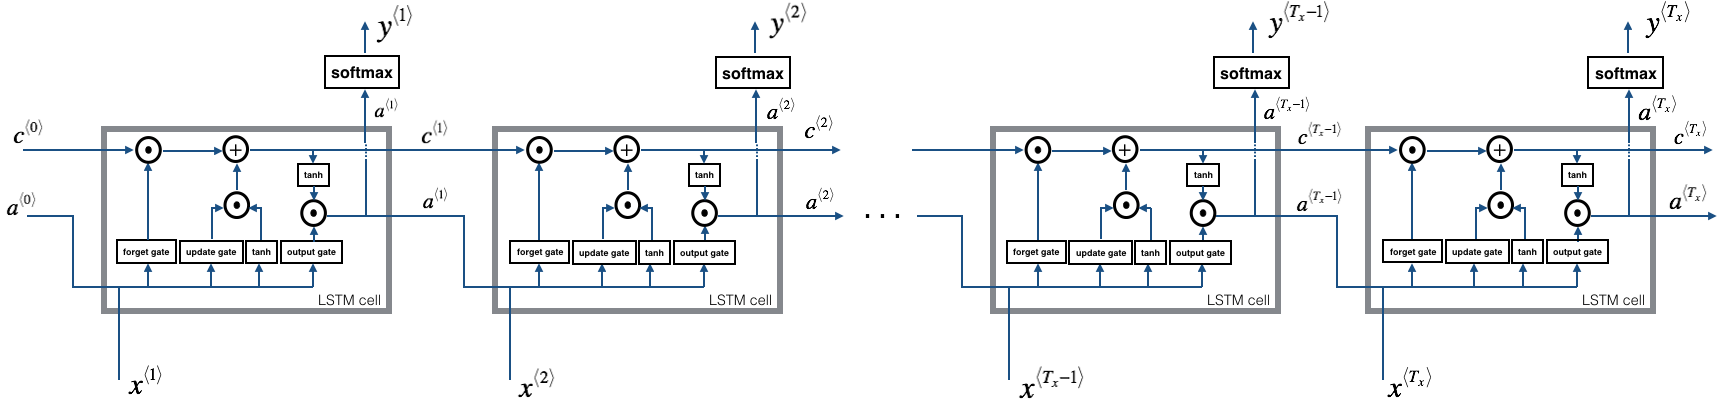
<caption><center><font color='lightblue'><b>Figure 5</b>: LSTM over multiple time steps. </center></caption>

<a name='ex-4'></a>    
### Exercise 4 - lstm_forward
    
Implement `lstm_forward()` to run an LSTM over $T_x$ time steps.

**Instructions**
* Get the dimensions $n_x, n_a, n_y, m, T_x$ from the shape of the variables: `x` and `parameters`
* Initialize the 3D tensors $a$, $c$ and $y$
    - $a$: hidden state, shape $(n_{a}, m, T_{x})$
    - $c$: cell state, shape $(n_{a}, m, T_{x})$
    - $y$: prediction, shape $(n_{y}, m, T_{x})$ (Note that $T_{y} = T_{x}$ in this example)
    - **Note** Setting one variable equal to the other is a "copy by reference".  In other words, don't do `c = a', otherwise both these variables point to the same underlying variable.
* Initialize the 2D tensor $a^{\langle t \rangle}$
    - $a^{\langle t \rangle}$ stores the hidden state for time step $t$.  The variable name is `a_next`.
    - $a^{\langle 0 \rangle}$, the initial hidden state at time step 0, is passed in when calling the function. The variable name is `a0`.
    - $a^{\langle t \rangle}$ and $a^{\langle 0 \rangle}$ represent a single time step, so they both have the shape  $(n_{a}, m)$
    - Initialize $a^{\langle t \rangle}$ by setting it to the initial hidden state ($a^{\langle 0 \rangle}$) that is passed into the function.
* Initialize $c^{\langle t \rangle}$ with zeros.
    - The variable name is `c_next`
    - $c^{\langle t \rangle}$ represents a single time step, so its shape is $(n_{a}, m)$
    - **Note**: create `c_next` as its own variable with its own location in memory.  Do not initialize it as a slice of the 3D tensor $c$.  In other words, **don't** do `c_next = c[:,:,0]`.
* For each time step, do the following:
    - From the 3D tensor $x$, get a 2D slice $x^{\langle t \rangle}$ at time step $t$
    - Call the `lstm_cell_forward` function that you defined previously, to get the hidden state, cell state, prediction, and cache
    - Store the hidden state, cell state and prediction (the 2D tensors) inside the 3D tensors
    - Append the cache to the list of caches

In [54]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: lstm_forward

def lstm_forward(x, a0, parameters):
    """
    Implement the forward propagation of the recurrent neural network using an LSTM-cell described in Figure (4).

    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        bi -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc -- Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        bo -- Bias of the output gate, numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)

    Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    c -- The value of the cell state, numpy array of shape (n_a, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of all the caches, x)
    """

    # Initialize "caches", which will track the list of all the caches
    caches = []

    ### START CODE HERE ###
    n_x, m, T_x = x.shape
    n_y, n_a = parameters["Wy"].shape

    # hidden state (activation)
    a = np.zeros((n_a, m, T_x))
    # cell state
    c = np.zeros((n_a, m, T_x))
    # prediction
    y = np.zeros((n_y, m, T_x))

    a_next = a0
    c_next = np.zeros((n_a, m))

    for t in range(T_x):
      x_t = x[:,:,t]

      a_next, c_next, yt_pred, cache = lstm_cell_forward(x_t, a_next, c_next, parameters)

      a[:,:,t] = a_next
      c[:,:,t] = c_next
      y[:,:,t] = yt_pred
      caches.append(cache)
    ### END CODE HERE ###

    # store values needed for backward propagation in cache
    caches = (caches, x)

    return a, y, c, caches

In [55]:
np.random.seed(1)
x_tmp = np.random.randn(3, 10, 7)
a0_tmp = np.random.randn(5, 10)
parameters_tmp = {}
parameters_tmp['Wf'] = np.random.randn(5, 5 + 3)
parameters_tmp['bf'] = np.random.randn(5, 1)
parameters_tmp['Wi'] = np.random.randn(5, 5 + 3)
parameters_tmp['bi']= np.random.randn(5, 1)
parameters_tmp['Wo'] = np.random.randn(5, 5 + 3)
parameters_tmp['bo'] = np.random.randn(5, 1)
parameters_tmp['Wc'] = np.random.randn(5, 5 + 3)
parameters_tmp['bc'] = np.random.randn(5, 1)
parameters_tmp['Wy'] = np.random.randn(2, 5)
parameters_tmp['by'] = np.random.randn(2, 1)

a_tmp, y_tmp, c_tmp, caches_tmp = lstm_forward(x_tmp, a0_tmp, parameters_tmp)
print("a[4][3][6] = ", a_tmp[4][3][6])
print("a.shape = ", a_tmp.shape)
print("y[1][4][3] =", y_tmp[1][4][3])
print("y.shape = ", y_tmp.shape)
print("caches[1][1][1] =\n", caches_tmp[1][1][1])
print("c[1][2][1]", c_tmp[1][2][1])
print("len(caches) = ", len(caches_tmp))

# UNIT TEST
lstm_forward_test(lstm_forward)

a[4][3][6] =  0.1721177675329167
a.shape =  (5, 10, 7)
y[1][4][3] = 0.9508734618501101
y.shape =  (2, 10, 7)
caches[1][1][1] =
 [ 0.82797464  0.23009474  0.76201118 -0.22232814 -0.20075807  0.18656139
  0.41005165]
c[1][2][1] -0.8555449167181983
len(caches) =  2
All tests passed


**Expected Output**:

```Python
a[4][3][6] =  0.172117767533
a.shape =  (5, 10, 7)
y[1][4][3] = 0.95087346185
y.shape =  (2, 10, 7)
caches[1][1][1] =
 [ 0.82797464  0.23009474  0.76201118 -0.22232814 -0.20075807  0.18656139
  0.41005165]
c[1][2][1] -0.855544916718
len(caches) =  2
```

### Congratulations!

You have now implemented the forward passes for both the basic RNN and the LSTM. When using a deep learning framework, implementing the forward pass is sufficient to build systems that achieve great performance. The framework will take care of the rest.

<font color='orange'><b>What you should remember</b>:

* An LSTM is similar to an RNN in that they both use hidden states to pass along information, but an LSTM also uses a cell state, which is like a long-term memory, to help deal with the issue of vanishing gradients
* An LSTM cell consists of a cell state, or long-term memory, a hidden state, or short-term memory, along with 3 gates that constantly update the relevancy of its inputs:
    * A <b>forget</b> gate, which decides which input units should be remembered and passed along. It's a tensor with values between 0 and 1.
        * If a unit has a value close to 0, the LSTM will "forget" the stored state in the previous cell state.
        * If it has a value close to 1, the LSTM will mostly remember the corresponding value.
    * An <b>update</b> gate, again a tensor containing values between 0 and 1. It decides on what information to throw away, and what new information to add.
        * When a unit in the update gate is close to 1, the value of its candidate is passed on to the hidden state.
        * When a unit in the update gate is close to 0, it's prevented from being passed onto the hidden state.
    * And an <b>output</b> gate, which decides what gets sent as the output of the time step
</font>

Let's recap all you've accomplished so far. You have:

* Used notation for building sequence models
* Become familiar with the architecture of a basic RNN and an LSTM, and can describe their components

The rest of this notebook is optional, and will not be graded, but as always, you are encouraged to push your own understanding! Good luck and have fun.

<a name='3'></a>    
## 3 - Backpropagation in Recurrent Neural Networks (OPTIONAL / UNGRADED)

In modern deep learning frameworks, you only have to implement the forward pass, and the framework takes care of the backward pass, so most deep learning engineers do not need to bother with the details of the backward pass. If, however, you are an expert in calculus (or are just curious) and want to see the details of backprop in RNNs, you can work through this optional portion of the notebook.

When in an earlier [course](https://www.coursera.org/learn/neural-networks-deep-learning/lecture/0VSHe/derivatives-with-a-computation-graph)  you implemented a simple (fully connected) neural network, you used backpropagation to compute the derivatives with respect to the cost to update the parameters. Similarly, in recurrent neural networks you can calculate the derivatives with respect to the cost in order to update the parameters. The backprop equations are quite complicated, and so were not derived in lecture. However, they're briefly presented for your viewing pleasure below.

<b>Note:</b> This notebook does not implement the backward path from the Loss 'J' backwards to 'a'. This would have included the dense layer and softmax, which are a part of the forward path. This is assumed to be calculated elsewhere and the result passed to `rnn_backward` in 'da'. It is further assumed that loss has been adjusted for batch size (m) and division by the number of examples is NOT required here.

This section is optional and ungraded, because it's more difficult and has fewer details regarding its implementation. Note that this section only implements key elements of the full path!

Onward, brave one:

<a name='3-1'></a>    
### 3.1 - Basic RNN  Backward Pass

Begin by computing the backward pass for the basic RNN cell. Then, in the following sections, iterate through the cells.

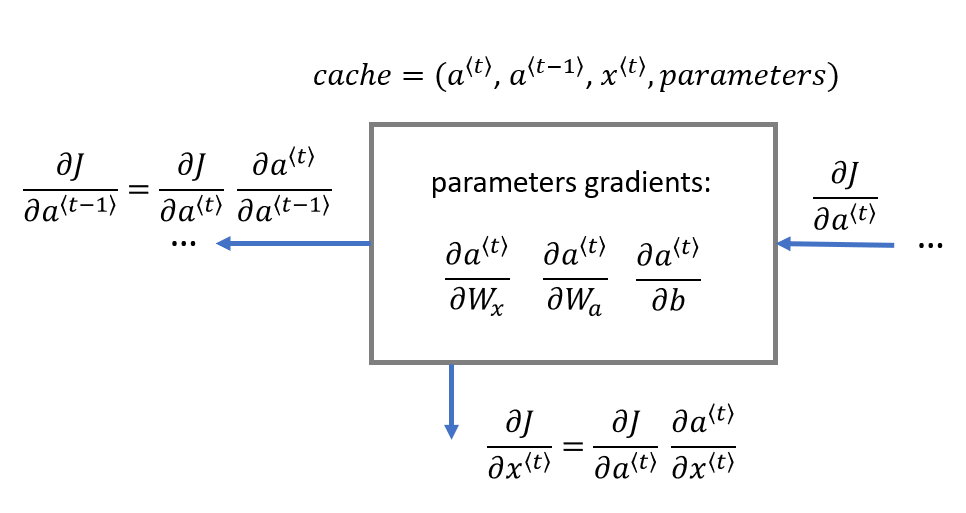
<caption><center><font color='lightblue'><b>Figure 6</b>: The RNN cell's backward pass. Just like in a fully-connected neural network, the derivative of the cost function $J$ backpropagates through the time steps of the RNN by following the chain rule from calculus. Internal to the cell, the chain rule is also used to calculate $(\frac{\partial J}{\partial W_{ax}},\frac{\partial J}{\partial W_{aa}},\frac{\partial J}{\partial b})$ to update the parameters $(W_{ax}, W_{aa}, b_a)$. The operation can utilize the cached results from the forward path. </center></caption>

Recall from lecture that the shorthand for the partial derivative of cost relative to a variable is `dVariable`. For example, $\frac{\partial J}{\partial W_{ax}}$ is $dW_{ax}$. This will be used throughout the remaining sections.

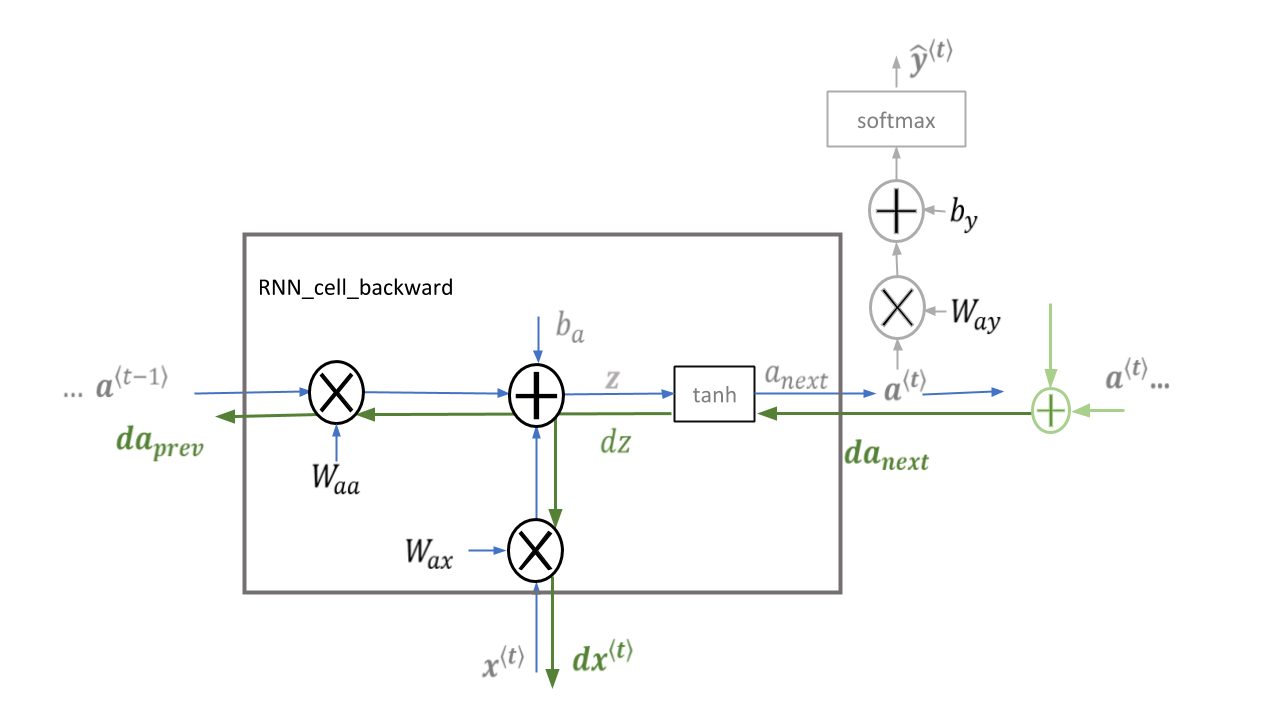
<caption><center><font color='lightblue'><b>Figure 7</b>: This implementation of `rnn_cell_backward` does **not** include the output dense layer and softmax which are included in `rnn_cell_forward`.  
$da_{next}$ is $\frac{\partial{J}}{\partial a^{\langle t \rangle}}$ and includes loss from previous stages and current stage output logic. The addition shown in green will be part of your implementation of `rnn_backward`.  </center></caption>

##### Equations
To compute `rnn_cell_backward`, you can use the following equations. It's a good exercise to derive them by hand. Here, $*$ denotes element-wise multiplication while the absence of a symbol indicates matrix multiplication.

\begin{align}
\displaystyle a^{\langle t \rangle} &= \tanh(W_{ax} x^{\langle t \rangle} + W_{aa} a^{\langle t-1 \rangle} + b_{a})\tag{-} \\[8pt]
\displaystyle \frac{\partial \tanh(x)} {\partial x} &= 1 - \tanh^2(x) \tag{-} \\[8pt]
\displaystyle {dtanh} &= da_{next} * ( 1 - \tanh^2(W_{ax}x^{\langle t \rangle}+W_{aa} a^{\langle t-1 \rangle} + b_{a})) \tag{0} \\[8pt]
\displaystyle  {dW_{ax}} &= dtanh \cdot x^{\langle t \rangle T}\tag{1} \\[8pt]
\displaystyle dW_{aa} &= dtanh \cdot a^{\langle t-1 \rangle T}\tag{2} \\[8pt]
\displaystyle db_a& = \sum_{batch}dtanh\tag{3} \\[8pt]
\displaystyle dx^{\langle t \rangle} &= { W_{ax}}^T \cdot dtanh\tag{4} \\[8pt]
\displaystyle da_{prev} &= { W_{aa}}^T \cdot dtanh\tag{5}
\end{align}



<a name='ex-5'></a>
### Exercise 5 - rnn_cell_backward

Implementing `rnn_cell_backward`.

The results can be computed directly by implementing the equations above. However, you have an option to simplify them by computing 'dz' and using the chain rule.  
This can be further simplified by noting that $\tanh(W_{ax}x^{\langle t \rangle}+W_{aa} a^{\langle t-1 \rangle} + b_{a})$ was computed and saved as `a_next` in the forward pass.

To calculate `dba`, the 'batch' above is a sum across all 'm' examples (axis= 1). Note that you should use the `keepdims = True` option.

It may be worthwhile to review Course 1 [Derivatives with a Computation Graph](https://www.coursera.org/learn/neural-networks-deep-learning/lecture/0VSHe/derivatives-with-a-computation-graph)  through  [Backpropagation Intuition](https://www.coursera.org/learn/neural-networks-deep-learning/lecture/6dDj7/backpropagation-intuition-optional), which decompose the calculation into steps using the chain rule.  
Matrix vector derivatives are described [here](http://cs231n.stanford.edu/vecDerivs.pdf), though the equations above incorporate the required transformations.

**Note**: `rnn_cell_backward` does **not** include the calculation of loss from $y \langle t \rangle$. This is incorporated into the incoming `da_next`. This is a slight mismatch with `rnn_cell_forward`, which includes a dense layer and softmax.

**Note on the code**:
  
$\displaystyle dx^{\langle t \rangle}$ is represented by dxt,   
$\displaystyle d W_{ax}$ is represented by dWax,   
$\displaystyle da_{prev}$ is represented by da_prev,    
$\displaystyle dW_{aa}$ is represented by dWaa,   
$\displaystyle db_{a}$ is represented by dba,   
`dz` is not derived above but can optionally be derived by students to simplify the repeated calculations.



In [12]:
# UNGRADED FUNCTION: rnn_cell_backward

def rnn_cell_backward(da_next, cache):
    """
    Implements the backward pass for the RNN-cell (single time-step).

    Arguments:
    da_next -- Gradient of loss with respect to next hidden state
    cache -- python dictionary containing useful values (output of rnn_cell_forward())

    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradients of input data, of shape (n_x, m)
                        da_prev -- Gradients of previous hidden state, of shape (n_a, m)
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dba -- Gradients of bias vector, of shape (n_a, 1)
    """

    # Retrieve values from cache
    (a_next, a_prev, xt, parameters) = cache

    # Retrieve values from parameters
    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]

    ### START CODE HERE ###
    # compute the gradient of dtanh term using a_next and da_next (≈1 line)
    dtanh = None

    # compute the gradient of the loss with respect to Wax (≈2 lines)
    dxt = None
    dWax = None

    # compute the gradient with respect to Waa (≈2 lines)
    da_prev = None
    dWaa = None

    # compute the gradient with respect to b (≈1 line)
    dba = None

    ### END CODE HERE ###

    # Store the gradients in a python dictionary
    gradients = {"dxt": dxt, "da_prev": da_prev, "dWax": dWax, "dWaa": dWaa, "dba": dba}

    return gradients

In [13]:
np.random.seed(1)
xt_tmp = np.random.randn(3,10)
a_prev_tmp = np.random.randn(5,10)
parameters_tmp = {}
parameters_tmp['Wax'] = np.random.randn(5,3)
parameters_tmp['Waa'] = np.random.randn(5,5)
parameters_tmp['Wya'] = np.random.randn(2,5)
parameters_tmp['ba'] = np.random.randn(5,1)
parameters_tmp['by'] = np.random.randn(2,1)

a_next_tmp, yt_tmp, cache_tmp = rnn_cell_forward(xt_tmp, a_prev_tmp, parameters_tmp)

da_next_tmp = np.random.randn(5,10)
gradients_tmp = rnn_cell_backward(da_next_tmp, cache_tmp)
print("gradients[\"dxt\"][1][2] =", gradients_tmp["dxt"][1][2])
print("gradients[\"dxt\"].shape =", gradients_tmp["dxt"].shape)
print("gradients[\"da_prev\"][2][3] =", gradients_tmp["da_prev"][2][3])
print("gradients[\"da_prev\"].shape =", gradients_tmp["da_prev"].shape)
print("gradients[\"dWax\"][3][1] =", gradients_tmp["dWax"][3][1])
print("gradients[\"dWax\"].shape =", gradients_tmp["dWax"].shape)
print("gradients[\"dWaa\"][1][2] =", gradients_tmp["dWaa"][1][2])
print("gradients[\"dWaa\"].shape =", gradients_tmp["dWaa"].shape)
print("gradients[\"dba\"][4] =", gradients_tmp["dba"][4])
print("gradients[\"dba\"].shape =", gradients_tmp["dba"].shape)

TypeError: ignored

**Expected Output**:

<table>
    <tr>
        <td>
            <b>gradients["dxt"][1][2]</b> =
        </td>
        <td>
           -1.3872130506
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dxt"].shape</b> =
        </td>
        <td>
           (3, 10)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["da_prev"][2][3]</b> =
        </td>
        <td>
           -0.152399493774
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["da_prev"].shape</b> =
        </td>
        <td>
           (5, 10)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWax"][3][1]</b> =
        </td>
        <td>
           0.410772824935
        </td>
    </tr>
            <tr>
        <td>
            <b>gradients["dWax"].shape</b> =
        </td>
        <td>
           (5, 3)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWaa"][1][2]</b> =
        </td>
        <td>
           1.15034506685
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWaa"].shape</b> =
        </td>
        <td>
           (5, 5)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dba"][4]</b> =
        </td>
        <td>
           [ 0.20023491]
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dba"].shape</b> =
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
</table>

<a name='ex-6'></a>
### Exercise 6 - rnn_backward

Computing the gradients of the cost with respect to $a^{\langle t \rangle}$ at every time step $t$ is useful because it is what helps the gradient backpropagate to the previous RNN cell. To do so, you need to iterate through all the time steps starting at the end, and at each step, you increment the overall $db_a$, $dW_{aa}$, $dW_{ax}$ and you store $dx$.

**Instructions**:

Implement the `rnn_backward` function. Initialize the return variables with zeros first, and then loop through all the time steps while calling the `rnn_cell_backward` at each time time step, updating the other variables accordingly.

* Note that this notebook does not implement the backward path from the Loss 'J' backwards to 'a'.
    * This would have included the dense layer and softmax which are a part of the forward path.
    * This is assumed to be calculated elsewhere and the result passed to `rnn_backward` in 'da'.
    * You must combine this with the loss from the previous stages when calling `rnn_cell_backward` (see figure 7 above).
* It is further assumed that loss has been adjusted for batch size (m).
    * Therefore, division by the number of examples is not required here.

In [ ]:
# UNGRADED FUNCTION: rnn_backward

def rnn_backward(da, caches):
    """
    Implement the backward pass for a RNN over an entire sequence of input data.

    Arguments:
    da -- Upstream gradients of all hidden states, of shape (n_a, m, T_x)
    caches -- tuple containing information from the forward pass (rnn_forward)

    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradient w.r.t. the input data, numpy-array of shape (n_x, m, T_x)
                        da0 -- Gradient w.r.t the initial hidden state, numpy-array of shape (n_a, m)
                        dWax -- Gradient w.r.t the input's weight matrix, numpy-array of shape (n_a, n_x)
                        dWaa -- Gradient w.r.t the hidden state's weight matrix, numpy-arrayof shape (n_a, n_a)
                        dba -- Gradient w.r.t the bias, of shape (n_a, 1)
    """

    ### START CODE HERE ###

    # Retrieve values from the first cache (t=1) of caches (≈2 lines)
    (caches, x) = caches
    (a1, a0, x1, parameters) = caches[0]

    # Retrieve dimensions from da's and x1's shapes (≈2 lines)
    n_a, m, T_x = da.shape
    n_x, m = x1.shape

    # initialize the gradients with the right sizes (≈6 lines)
    dx = None
    dWax = None
    dWaa = None
    dba = None
    da0 = None
    da_prevt = None

    # Loop through all the time steps
    for t in reversed(range(T_x)):
        # Compute gradients at time step t. Choose wisely the "da_next" and the "cache" to use in the backward propagation step. (≈1 line)
        gradients = None
        # Retrieve derivatives from gradients (≈ 1 line)
        dxt, da_prevt, dWaxt, dWaat, dbat = gradients["dxt"], gradients["da_prev"], gradients["dWax"], gradients["dWaa"], gradients["dba"]
        # Increment global derivatives w.r.t parameters by adding their derivative at time-step t (≈4 lines)
        dx[:, :, t] = None
        dWax += None
        dWaa += None
        dba += None

    # Set da0 to the gradient of a which has been backpropagated through all time-steps (≈1 line)
    da0 = None
    ### END CODE HERE ###

    # Store the gradients in a python dictionary
    gradients = {"dx": dx, "da0": da0, "dWax": dWax, "dWaa": dWaa,"dba": dba}

    return gradients

In [ ]:
np.random.seed(1)
x_tmp = np.random.randn(3,10,4)
a0_tmp = np.random.randn(5,10)
parameters_tmp = {}
parameters_tmp['Wax'] = np.random.randn(5,3)
parameters_tmp['Waa'] = np.random.randn(5,5)
parameters_tmp['Wya'] = np.random.randn(2,5)
parameters_tmp['ba'] = np.random.randn(5,1)
parameters_tmp['by'] = np.random.randn(2,1)

a_tmp, y_tmp, caches_tmp = rnn_forward(x_tmp, a0_tmp, parameters_tmp)
da_tmp = np.random.randn(5, 10, 4)
gradients_tmp = rnn_backward(da_tmp, caches_tmp)

print("gradients[\"dx\"][1][2] =", gradients_tmp["dx"][1][2])
print("gradients[\"dx\"].shape =", gradients_tmp["dx"].shape)
print("gradients[\"da0\"][2][3] =", gradients_tmp["da0"][2][3])
print("gradients[\"da0\"].shape =", gradients_tmp["da0"].shape)
print("gradients[\"dWax\"][3][1] =", gradients_tmp["dWax"][3][1])
print("gradients[\"dWax\"].shape =", gradients_tmp["dWax"].shape)
print("gradients[\"dWaa\"][1][2] =", gradients_tmp["dWaa"][1][2])
print("gradients[\"dWaa\"].shape =", gradients_tmp["dWaa"].shape)
print("gradients[\"dba\"][4] =", gradients_tmp["dba"][4])
print("gradients[\"dba\"].shape =", gradients_tmp["dba"].shape)

**Expected Output**:

<table>
    <tr>
        <td>
            <b>gradients["dx"][1][2]</b> =
        </td>
        <td>
           [-2.07101689 -0.59255627  0.02466855  0.01483317]
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dx"].shape</b> =
        </td>
        <td>
           (3, 10, 4)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["da0"][2][3]</b> =
        </td>
        <td>
           -0.314942375127
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["da0"].shape</b> =
        </td>
        <td>
           (5, 10)
        </td>
    </tr>
         <tr>
        <td>
            <b>gradients["dWax"][3][1]</b> =
        </td>
        <td>
           11.2641044965
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWax"].shape</b> =
        </td>
        <td>
           (5, 3)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWaa"][1][2]</b> =
        </td>
        <td>
           2.30333312658
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWaa"].shape</b> =
        </td>
        <td>
           (5, 5)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dba"][4]</b> =
        </td>
        <td>
           [-0.74747722]
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dba"].shape</b> =
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
</table>

<a name='3-2'></a>
### 3.2 - LSTM Backward Pass

#### 1. One Step Backward
The LSTM backward pass is slightly more complicated than the forward pass.

<img src="images/LSTM_cell_backward_rev3a_c2.png" style="width:500;height:400px;"> <br>
<caption><center><font color='purple'><b>Figure 8</b>: LSTM Cell Backward. Note the output functions, while part of the `lstm_cell_forward`, are not included in `lstm_cell_backward` </center></caption>

The equations for the LSTM backward pass are provided below. (If you enjoy calculus exercises feel free to try deriving these from scratch yourself.)

#### 2. Gate Derivatives
Note the location of the gate derivatives ($\gamma$..) between the dense layer and the activation function (see graphic above). This is convenient for computing parameter derivatives in the next step.
\begin{align}
d\gamma_o^{\langle t \rangle} &= da_{next}*\tanh(c_{next}) * \Gamma_o^{\langle t \rangle}*\left(1-\Gamma_o^{\langle t \rangle}\right)\tag{7} \\[8pt]
dp\widetilde{c}^{\langle t \rangle} &= \left(dc_{next}*\Gamma_u^{\langle t \rangle}+ \Gamma_o^{\langle t \rangle}* (1-\tanh^2(c_{next})) * \Gamma_u^{\langle t \rangle} * da_{next} \right) * \left(1-\left(\widetilde c^{\langle t \rangle}\right)^2\right) \tag{8} \\[8pt]
d\gamma_u^{\langle t \rangle} &= \left(dc_{next}*\widetilde{c}^{\langle t \rangle} + \Gamma_o^{\langle t \rangle}* (1-\tanh^2(c_{next})) * \widetilde{c}^{\langle t \rangle} * da_{next}\right)*\Gamma_u^{\langle t \rangle}*\left(1-\Gamma_u^{\langle t \rangle}\right)\tag{9} \\[8pt]
d\gamma_f^{\langle t \rangle} &= \left(dc_{next}* c_{prev} + \Gamma_o^{\langle t \rangle} * (1-\tanh^2(c_{next})) * c_{prev} * da_{next}\right)*\Gamma_f^{\langle t \rangle}*\left(1-\Gamma_f^{\langle t \rangle}\right)\tag{10}
\end{align}

#### 3. Parameter Derivatives

$ dW_f = d\gamma_f^{\langle t \rangle} \begin{bmatrix} a_{prev} \\ x_t\end{bmatrix}^T \tag{11} $
$ dW_u = d\gamma_u^{\langle t \rangle} \begin{bmatrix} a_{prev} \\ x_t\end{bmatrix}^T \tag{12} $
$ dW_c = dp\widetilde c^{\langle t \rangle} \begin{bmatrix} a_{prev} \\ x_t\end{bmatrix}^T \tag{13} $
$ dW_o = d\gamma_o^{\langle t \rangle} \begin{bmatrix} a_{prev} \\ x_t\end{bmatrix}^T \tag{14}$

To calculate $db_f, db_u, db_c, db_o$ you just need to sum across all 'm' examples (axis= 1) on $d\gamma_f^{\langle t \rangle}, d\gamma_u^{\langle t \rangle}, dp\widetilde c^{\langle t \rangle}, d\gamma_o^{\langle t \rangle}$ respectively. Note that you should have the `keepdims = True` option.

$\displaystyle db_f = \sum_{batch}d\gamma_f^{\langle t \rangle}\tag{15}$
$\displaystyle db_u = \sum_{batch}d\gamma_u^{\langle t \rangle}\tag{16}$
$\displaystyle db_c = \sum_{batch}d\gamma_c^{\langle t \rangle}\tag{17}$
$\displaystyle db_o = \sum_{batch}d\gamma_o^{\langle t \rangle}\tag{18}$

Finally, you will compute the derivative with respect to the previous hidden state, previous memory state, and input.

$ da_{prev} = W_f^T d\gamma_f^{\langle t \rangle} + W_u^T   d\gamma_u^{\langle t \rangle}+ W_c^T dp\widetilde c^{\langle t \rangle} + W_o^T d\gamma_o^{\langle t \rangle} \tag{19}$

Here, to account for concatenation, the weights for equations 19 are the first n_a, (i.e. $W_f = W_f[:,:n_a]$ etc...)

$ dc_{prev} = dc_{next}*\Gamma_f^{\langle t \rangle} + \Gamma_o^{\langle t \rangle} * (1- \tanh^2(c_{next}))*\Gamma_f^{\langle t \rangle}*da_{next} \tag{20}$

$ dx^{\langle t \rangle} = W_f^T d\gamma_f^{\langle t \rangle} + W_u^T  d\gamma_u^{\langle t \rangle}+ W_c^T dp\widetilde c^{\langle t \rangle} + W_o^T d\gamma_o^{\langle t \rangle}\tag{21} $

where the weights for equation 21 are from n_a to the end, (i.e. $W_f = W_f[:,n_a:]$ etc...)

<a name='ex-7'></a>
### Exercise 7 - lstm_cell_backward

Implement `lstm_cell_backward` by implementing equations $7-21$ below.
  
    
**Note**:

In the code:

$d\gamma_o^{\langle t \rangle}$ is represented by  `dot`,    
$dp\widetilde{c}^{\langle t \rangle}$ is represented by  `dcct`,  
$d\gamma_u^{\langle t \rangle}$ is represented by  `dit`,  
$d\gamma_f^{\langle t \rangle}$ is represented by  `dft`

In [ ]:
# UNGRADED FUNCTION: lstm_cell_backward

def lstm_cell_backward(da_next, dc_next, cache):
    """
    Implement the backward pass for the LSTM-cell (single time-step).

    Arguments:
    da_next -- Gradients of next hidden state, of shape (n_a, m)
    dc_next -- Gradients of next cell state, of shape (n_a, m)
    cache -- cache storing information from the forward pass

    Returns:
    gradients -- python dictionary containing:
                        dxt -- Gradient of input data at time-step t, of shape (n_x, m)
                        da_prev -- Gradient w.r.t. the previous hidden state, numpy array of shape (n_a, m)
                        dc_prev -- Gradient w.r.t. the previous memory state, of shape (n_a, m, T_x)
                        dWf -- Gradient w.r.t. the weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        dWi -- Gradient w.r.t. the weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        dWc -- Gradient w.r.t. the weight matrix of the memory gate, numpy array of shape (n_a, n_a + n_x)
                        dWo -- Gradient w.r.t. the weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        dbf -- Gradient w.r.t. biases of the forget gate, of shape (n_a, 1)
                        dbi -- Gradient w.r.t. biases of the update gate, of shape (n_a, 1)
                        dbc -- Gradient w.r.t. biases of the memory gate, of shape (n_a, 1)
                        dbo -- Gradient w.r.t. biases of the output gate, of shape (n_a, 1)
    """

    # Retrieve information from "cache"
    (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters) = cache

    ### START CODE HERE ###
    # Retrieve dimensions from xt's and a_next's shape (≈2 lines)
    n_x, m = None
    n_a, m = None

    # Compute gates related derivatives. Their values can be found by looking carefully at equations (7) to (10) (≈4 lines)
    dot = None
    dcct = None
    dit = None
    dft = None

    # Compute parameters related derivatives. Use equations (11)-(18) (≈8 lines)
    dWf = None
    dWi = None
    dWc = None
    dWo = None
    dbf = None
    dbi = None
    dbc = None
    dbo = None

    # Compute derivatives w.r.t previous hidden state, previous memory state and input. Use equations (19)-(21). (≈3 lines)
    da_prev = None
    dc_prev = None
    dxt = None
    ### END CODE HERE ###



    # Save gradients in dictionary
    gradients = {"dxt": dxt, "da_prev": da_prev, "dc_prev": dc_prev, "dWf": dWf,"dbf": dbf, "dWi": dWi,"dbi": dbi,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}

    return gradients

In [ ]:
np.random.seed(1)
xt_tmp = np.random.randn(3,10)
a_prev_tmp = np.random.randn(5,10)
c_prev_tmp = np.random.randn(5,10)
parameters_tmp = {}
parameters_tmp['Wf'] = np.random.randn(5, 5+3)
parameters_tmp['bf'] = np.random.randn(5,1)
parameters_tmp['Wi'] = np.random.randn(5, 5+3)
parameters_tmp['bi'] = np.random.randn(5,1)
parameters_tmp['Wo'] = np.random.randn(5, 5+3)
parameters_tmp['bo'] = np.random.randn(5,1)
parameters_tmp['Wc'] = np.random.randn(5, 5+3)
parameters_tmp['bc'] = np.random.randn(5,1)
parameters_tmp['Wy'] = np.random.randn(2,5)
parameters_tmp['by'] = np.random.randn(2,1)

a_next_tmp, c_next_tmp, yt_tmp, cache_tmp = lstm_cell_forward(xt_tmp, a_prev_tmp, c_prev_tmp, parameters_tmp)

da_next_tmp = np.random.randn(5,10)
dc_next_tmp = np.random.randn(5,10)
gradients_tmp = lstm_cell_backward(da_next_tmp, dc_next_tmp, cache_tmp)
print("gradients[\"dxt\"][1][2] =", gradients_tmp["dxt"][1][2])
print("gradients[\"dxt\"].shape =", gradients_tmp["dxt"].shape)
print("gradients[\"da_prev\"][2][3] =", gradients_tmp["da_prev"][2][3])
print("gradients[\"da_prev\"].shape =", gradients_tmp["da_prev"].shape)
print("gradients[\"dc_prev\"][2][3] =", gradients_tmp["dc_prev"][2][3])
print("gradients[\"dc_prev\"].shape =", gradients_tmp["dc_prev"].shape)
print("gradients[\"dWf\"][3][1] =", gradients_tmp["dWf"][3][1])
print("gradients[\"dWf\"].shape =", gradients_tmp["dWf"].shape)
print("gradients[\"dWi\"][1][2] =", gradients_tmp["dWi"][1][2])
print("gradients[\"dWi\"].shape =", gradients_tmp["dWi"].shape)
print("gradients[\"dWc\"][3][1] =", gradients_tmp["dWc"][3][1])
print("gradients[\"dWc\"].shape =", gradients_tmp["dWc"].shape)
print("gradients[\"dWo\"][1][2] =", gradients_tmp["dWo"][1][2])
print("gradients[\"dWo\"].shape =", gradients_tmp["dWo"].shape)
print("gradients[\"dbf\"][4] =", gradients_tmp["dbf"][4])
print("gradients[\"dbf\"].shape =", gradients_tmp["dbf"].shape)
print("gradients[\"dbi\"][4] =", gradients_tmp["dbi"][4])
print("gradients[\"dbi\"].shape =", gradients_tmp["dbi"].shape)
print("gradients[\"dbc\"][4] =", gradients_tmp["dbc"][4])
print("gradients[\"dbc\"].shape =", gradients_tmp["dbc"].shape)
print("gradients[\"dbo\"][4] =", gradients_tmp["dbo"][4])
print("gradients[\"dbo\"].shape =", gradients_tmp["dbo"].shape)

**Expected Output**:

<table>
    <tr>
        <td>
            <b>gradients["dxt"][1][2]</b> =
        </td>
        <td>
           3.23055911511
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dxt"].shape</b> =
        </td>
        <td>
           (3, 10)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["da_prev"][2][3]</b> =
        </td>
        <td>
           -0.0639621419711
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["da_prev"].shape</b> =
        </td>
        <td>
           (5, 10)
        </td>
    </tr>
         <tr>
        <td>
            <b>gradients["dc_prev"][2][3]</b> =
        </td>
        <td>
           0.797522038797
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dc_prev"].shape</b> =
        </td>
        <td>
           (5, 10)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWf"][3][1]</b> =
        </td>
        <td>
           -0.147954838164
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWf"].shape</b> =
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWi"][1][2]</b> =
        </td>
        <td>
           1.05749805523
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWi"].shape</b> =
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
    <tr>
        <td>
            <b>gradients["dWc"][3][1]</b> =
        </td>
        <td>
           2.30456216369
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWc"].shape</b> =
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
    <tr>
        <td>
            <b>gradients["dWo"][1][2]</b> =
        </td>
        <td>
           0.331311595289
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWo"].shape</b> =
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
    <tr>
        <td>
            <b>gradients["dbf"][4]</b> =
        </td>
        <td>
           [ 0.18864637]
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dbf"].shape</b> =
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
    <tr>
        <td>
            <b>gradients["dbi"][4]</b> =
        </td>
        <td>
           [-0.40142491]
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dbi"].shape</b> =
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dbc"][4]</b> =
        </td>
        <td>
           [ 0.25587763]
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dbc"].shape</b> =
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dbo"][4]</b> =
        </td>
        <td>
           [ 0.13893342]
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dbo"].shape</b> =
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
</table>

<a name='3-3'></a>
### 3.3 Backward Pass through the LSTM RNN

This part is very similar to the `rnn_backward` function you implemented above. You will first create variables of the same dimension as your return variables. You will then iterate over all the time steps starting from the end and call the one step function you implemented for LSTM at each iteration. You will then update the parameters by summing them individually. Finally return a dictionary with the new gradients.

<a name='ex-8'></a>
### Exercise 8 - lstm_backward

Implement the `lstm_backward` function.

**Instructions**: Create a for loop starting from $T_x$ and going backward. For each step, call `lstm_cell_backward` and update your old gradients by adding the new gradients to them. Note that `dxt` is not updated, but is stored.

In [ ]:
# UNGRADED FUNCTION: lstm_backward

def lstm_backward(da, caches):

    """
    Implement the backward pass for the RNN with LSTM-cell (over a whole sequence).

    Arguments:
    da -- Gradients w.r.t the hidden states, numpy-array of shape (n_a, m, T_x)
    caches -- cache storing information from the forward pass (lstm_forward)

    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradient of inputs, of shape (n_x, m, T_x)
                        da0 -- Gradient w.r.t. the previous hidden state, numpy array of shape (n_a, m)
                        dWf -- Gradient w.r.t. the weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        dWi -- Gradient w.r.t. the weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        dWc -- Gradient w.r.t. the weight matrix of the memory gate, numpy array of shape (n_a, n_a + n_x)
                        dWo -- Gradient w.r.t. the weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        dbf -- Gradient w.r.t. biases of the forget gate, of shape (n_a, 1)
                        dbi -- Gradient w.r.t. biases of the update gate, of shape (n_a, 1)
                        dbc -- Gradient w.r.t. biases of the memory gate, of shape (n_a, 1)
                        dbo -- Gradient w.r.t. biases of the output gate, of shape (n_a, 1)
    """

    # Retrieve values from the first cache (t=1) of caches.
    (caches, x) = caches
    (a1, c1, a0, c0, f1, i1, cc1, o1, x1, parameters) = caches[0]

    ### START CODE HERE ###
    # Retrieve dimensions from da's and x1's shapes (≈2 lines)
    n_a, m, T_x = None
    n_x, m = None

    # initialize the gradients with the right sizes (≈12 lines)
    dx = None
    da0 = None
    da_prevt = None
    dc_prevt = None
    dWf = None
    dWi = None
    dWc = None
    dWo = None
    dbf = None
    dbi = None
    dbc = None
    dbo = None

    # loop back over the whole sequence
    for t in reversed(range(None)):
        # Compute all gradients using lstm_cell_backward
        gradients = None
        # Store or add the gradient to the parameters' previous step's gradient
        da_prevt = None
        dc_prevt = None
        dx[:,:,t] = None
        dWf += None
        dWi += None
        dWc += None
        dWo += None
        dbf += None
        dbi += None
        dbc += None
        dbo += None
    # Set the first activation's gradient to the backpropagated gradient da_prev.
    da0 = None

    ### END CODE HERE ###

    # Store the gradients in a python dictionary
    gradients = {"dx": dx, "da0": da0, "dWf": dWf,"dbf": dbf, "dWi": dWi,"dbi": dbi,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}

    return gradients

In [ ]:
np.random.seed(1)
x_tmp = np.random.randn(3,10,7)
a0_tmp = np.random.randn(5,10)

parameters_tmp = {}
parameters_tmp['Wf'] = np.random.randn(5, 5+3)
parameters_tmp['bf'] = np.random.randn(5,1)
parameters_tmp['Wi'] = np.random.randn(5, 5+3)
parameters_tmp['bi'] = np.random.randn(5,1)
parameters_tmp['Wo'] = np.random.randn(5, 5+3)
parameters_tmp['bo'] = np.random.randn(5,1)
parameters_tmp['Wc'] = np.random.randn(5, 5+3)
parameters_tmp['bc'] = np.random.randn(5,1)
parameters_tmp['Wy'] = np.zeros((2,5))       # unused, but needed for lstm_forward
parameters_tmp['by'] = np.zeros((2,1))       # unused, but needed for lstm_forward

a_tmp, y_tmp, c_tmp, caches_tmp = lstm_forward(x_tmp, a0_tmp, parameters_tmp)

da_tmp = np.random.randn(5, 10, 4)
gradients_tmp = lstm_backward(da_tmp, caches_tmp)

print("gradients[\"dx\"][1][2] =", gradients_tmp["dx"][1][2])
print("gradients[\"dx\"].shape =", gradients_tmp["dx"].shape)
print("gradients[\"da0\"][2][3] =", gradients_tmp["da0"][2][3])
print("gradients[\"da0\"].shape =", gradients_tmp["da0"].shape)
print("gradients[\"dWf\"][3][1] =", gradients_tmp["dWf"][3][1])
print("gradients[\"dWf\"].shape =", gradients_tmp["dWf"].shape)
print("gradients[\"dWi\"][1][2] =", gradients_tmp["dWi"][1][2])
print("gradients[\"dWi\"].shape =", gradients_tmp["dWi"].shape)
print("gradients[\"dWc\"][3][1] =", gradients_tmp["dWc"][3][1])
print("gradients[\"dWc\"].shape =", gradients_tmp["dWc"].shape)
print("gradients[\"dWo\"][1][2] =", gradients_tmp["dWo"][1][2])
print("gradients[\"dWo\"].shape =", gradients_tmp["dWo"].shape)
print("gradients[\"dbf\"][4] =", gradients_tmp["dbf"][4])
print("gradients[\"dbf\"].shape =", gradients_tmp["dbf"].shape)
print("gradients[\"dbi\"][4] =", gradients_tmp["dbi"][4])
print("gradients[\"dbi\"].shape =", gradients_tmp["dbi"].shape)
print("gradients[\"dbc\"][4] =", gradients_tmp["dbc"][4])
print("gradients[\"dbc\"].shape =", gradients_tmp["dbc"].shape)
print("gradients[\"dbo\"][4] =", gradients_tmp["dbo"][4])
print("gradients[\"dbo\"].shape =", gradients_tmp["dbo"].shape)

**Expected Output**:

<table>
    <tr>
        <td>
            <b>gradients["dx"][1][2]</b> =
        </td>
        <td>
           [0.00218254  0.28205375 -0.48292508 -0.43281115]
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dx"].shape</b> =
        </td>
        <td>
           (3, 10, 4)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["da0"][2][3]</b> =
        </td>
        <td>
           0.312770310257
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["da0"].shape</b> =
        </td>
        <td>
           (5, 10)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWf"][3][1]</b> =
        </td>
        <td>
           -0.0809802310938
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWf"].shape</b> =
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWi"][1][2]</b> =
        </td>
        <td>
           0.40512433093
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWi"].shape</b> =
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
    <tr>
        <td>
            <b>gradients["dWc"][3][1]</b> =
        </td>
        <td>
           -0.0793746735512
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWc"].shape</b> =
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
    <tr>
        <td>
            <b>gradients["dWo"][1][2]</b> =
        </td>
        <td>
           0.038948775763
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dWo"].shape</b> =
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
    <tr>
        <td>
            <b>gradients["dbf"][4]</b> =
        </td>
        <td>
           [-0.15745657]
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dbf"].shape</b> =
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
    <tr>
        <td>
            <b>gradients["dbi"][4]</b> =
        </td>
        <td>
           [-0.50848333]
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dbi"].shape</b> =
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dbc"][4]</b> =
        </td>
        <td>
           [-0.42510818]
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dbc"].shape</b> =
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dbo"][4]</b> =
        </td>
        <td>
           [ -0.17958196]
        </td>
    </tr>
        <tr>
        <td>
            <b>gradients["dbo"].shape</b> =
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
</table>

### Congratulations on completing this assignment!

You now understand how recurrent neural networks work! In the next exercise, you'll use an RNN to build a character-level language model. See you there!